## Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RANSACRegressor

## Initialize the models

In [3]:
linear_reg = LinearRegression()
svr = SVR(kernel='linear')
decision_tree_reg = DecisionTreeRegressor()
random_forest_reg = RandomForestRegressor(n_estimators=50)
gradient_boosting_reg = GradientBoostingRegressor()
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])

## Loading data

In [4]:
data = pd.read_csv('50_Startups.csv')

In [5]:
data.head(), data.shape

(   R&D Spend  Administration  Marketing Spend     Profit
 0  165349.20       136897.80        471784.10  192261.83
 1  162597.70       151377.59        443898.53  191792.06
 2  153441.51       101145.55        407934.54  191050.39
 3  144372.41       118671.85        383199.62  182901.99
 4  142107.34        91391.77        366168.42  166187.94,
 (50, 4))

In [6]:
data.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
Profit             float64
dtype: object

In [7]:
data.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
Profit             0
dtype: int64

In [8]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


Here, we can that the min contains zero val in R&D Spend and Marketing spend which should not be zero there

## Data Preprocessing

Imputing missing values, with the average over the same data

In [9]:
# Calculate the mean of "Administration" excluding zero values
mean1 = data[data['R&D Spend'] != 0]['R&D Spend'].mean()
mean2 = data[data["Marketing Spend"] != 0]['Marketing Spend'].mean()

# Impute zero values with the calculated mean
data.loc[data['R&D Spend'] == 0, 'R&D Spend'] = mean1
data.loc[data['Marketing Spend'] == 0, 'Marketing Spend'] = mean2

In [10]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,76793.349583,121344.639600,224494.784894,112012.639200
std,43312.151465,28017.802755,109792.846033,40306.180338
min,542.050000,51283.140000,1903.930000,14681.400000
25%,46117.032500,103730.875000,142431.385000,90138.902500
50%,75791.365000,122699.795000,224494.784894,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


Removal of outliers

<Axes: >

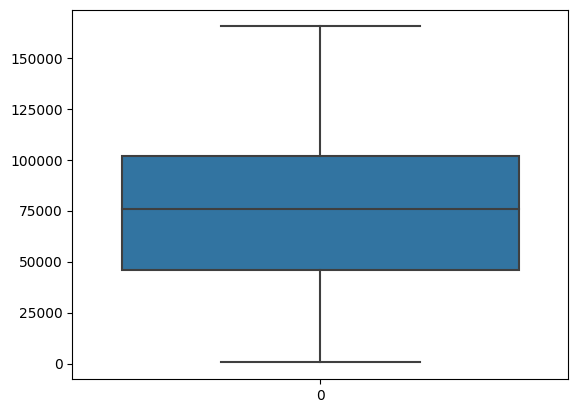

In [11]:
sns.boxplot(data["R&D Spend"])

<Axes: >

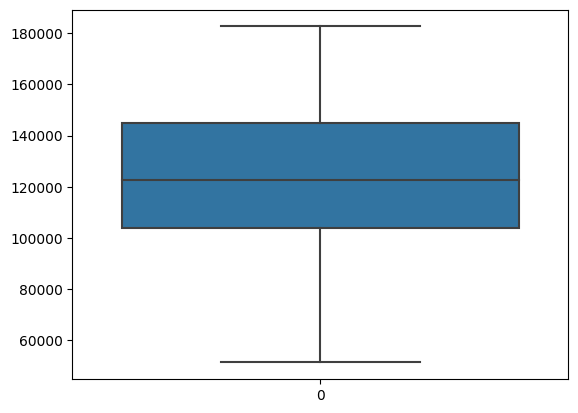

In [12]:
sns.boxplot(data["Administration"])

<Axes: >

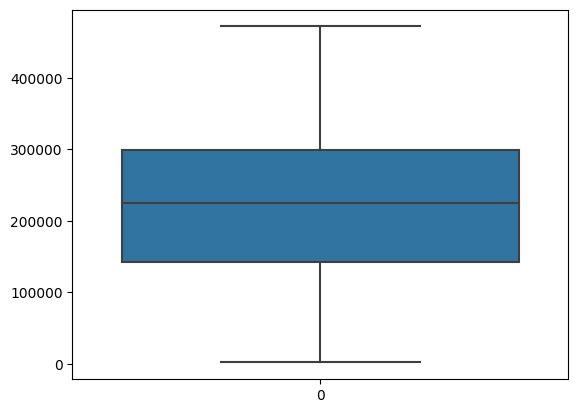

In [13]:
sns.boxplot(data["Marketing Spend"])

<Axes: >

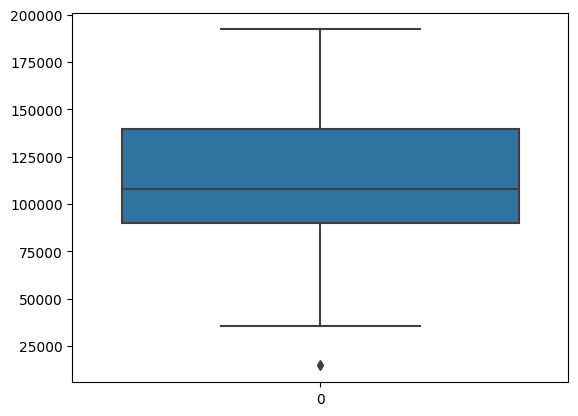

In [14]:
sns.boxplot(data["Profit"])

Here, all of the data looks fine. So no need to remove the outliers

In [15]:
Main_data = data.copy()

## Linear Regression

OLS Assumptions

In [16]:
cols = data.columns
cols

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'Profit'], dtype='object')

array([[<Axes: title={'center': 'R&D Spend'}>,
        <Axes: title={'center': 'Administration'}>],
       [<Axes: title={'center': 'Marketing Spend'}>,
        <Axes: title={'center': 'Profit'}>]], dtype=object)

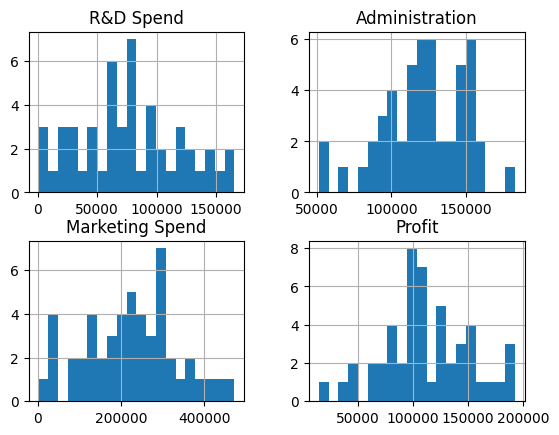

In [17]:
plot_data = data[cols]
plot_data.hist(bins=20)

Here, the data is normally distributed. Great !!

Linearity and Homoscacidity

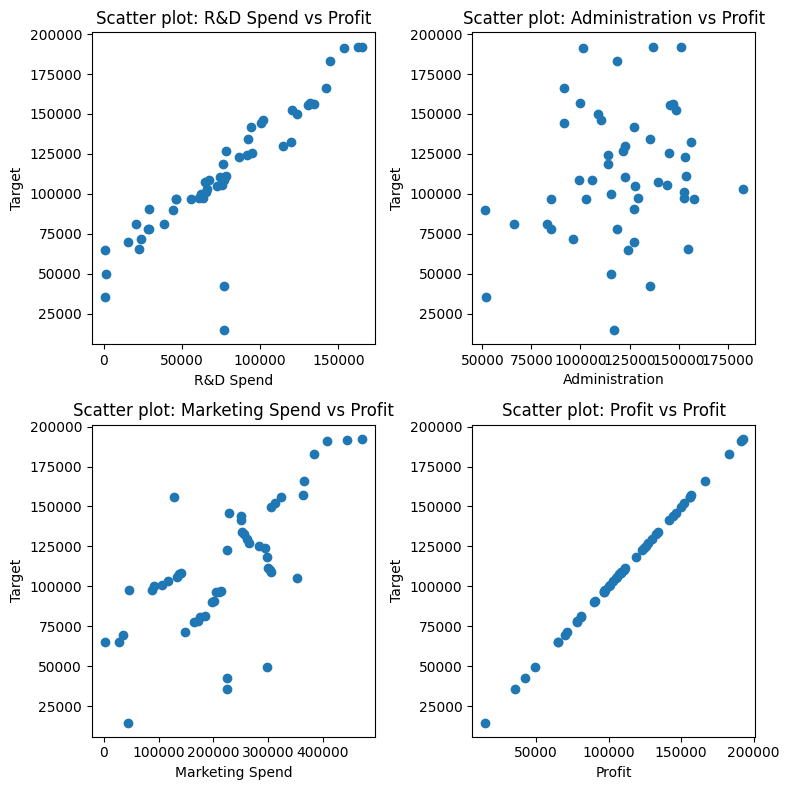

In [18]:
# Determine the number of rows and columns for the grid
r = 2
c = 2
fig, axes = plt.subplots(r, c, figsize=(8, 8))

# Iterate over the columns and plot scatter plots
for i, column in enumerate(cols):
    row = i // c  # Calculate the row index
    col = i % c  # Calculate the column index
    axes[row, col].scatter(data[column], data['Profit'])
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Target')
    axes[row, col].set_title(f'Scatter plot: {column} vs Profit')

# Adjust the layout and spacing
plt.tight_layout()

# Display the plot
plt.show()

Here the independent variables are also linear

Multicollinearity

In [19]:
cols = data.columns[:3]
# cols.remove(3)
cols

Index(['R&D Spend', 'Administration', 'Marketing Spend'], dtype='object')

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = data[cols]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns

In [21]:
vif

,VIF,Features
0,8.486858,R&D Spend
1,4.901511,Administration
2,7.884528,Marketing Spend


Since, VIF of R&D Spend and Makrjeting spend are below 10. So we will accept it

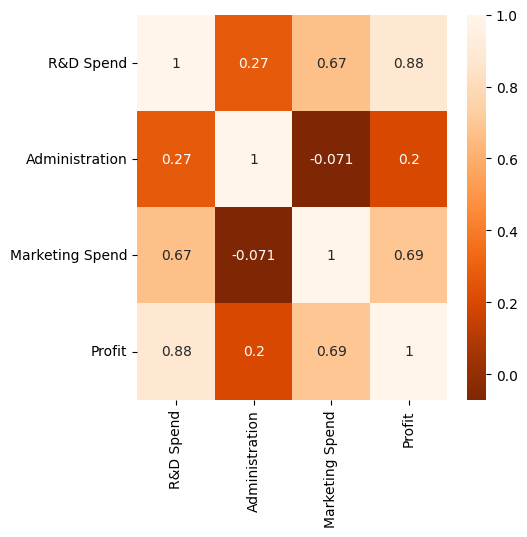

In [22]:
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(),annot=True,cmap='Oranges_r')
plt.show()

Feature selection

Dividing my data into train and test set


Since, there is a bell-curve in my data so standardization is more preferable.  normalization will compress these values into a small range.

In [23]:
X = data[['R&D Spend', 'Administration', 'Marketing Spend']]
y = data['Profit']

In [24]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
sc = StandardScaler()
X = sc.fit_transform(X)

X = pd.DataFrame(columns = ['R&D Spend', 'Administration', 'Marketing Spend'], data = X)

In [25]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
# Split the data into features (X) and target variable (y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [26]:
len(X_train)

42

In [27]:
# Functions that plots the actual versus predicted values
def plottings(actual_values, predicted_values):
    plt.scatter(actual_values, predicted_values)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')

    # Add a line of best fit or regression line
    line_of_best_fit = np.polyfit(actual_values, predicted_values, 1)
    plt.plot(actual_values, np.polyval(line_of_best_fit, actual_values), color='red')

    plt.show()

Creating a K cross fold validation function to select best model

In [28]:
def k_cross_fold(x_train, y_train, model, k):
  Rmse = float("inf")
  pre = None
  intercept = None
  prev = None
  coeff = None
  lg = len(x_train)
  split_amount = int(lg/k)
  best_model = None
  for i in range(k):
      if i == 0:
        train_x = x_train.iloc[split_amount*(i+1) : ]
        train_y = y_train[split_amount*(i+1) : ]
        test_x = x_train.iloc[ : split_amount*(i+1)]
        test_y = y_train[ : split_amount*(i+1)]

      elif i == k-1:
        train_x = x_train.iloc[ : split_amount*(i)]
        train_y = y_train[ : split_amount*(i)]
        test_x = x_train.iloc[split_amount*(i) : ]
        test_y = y_train[split_amount*(i) : ]

      else :
        test_x = x_train.iloc[int(split_amount* (i)) : int(split_amount* (i+1))]
        test_y =  y_train[int(split_amount* (i)) : int(split_amount* (i+1))]
        train_x = x_train.iloc[ : int(split_amount* (i))]
        train_x = np.append(train_x, x_train.iloc[int(split_amount* (i+1)) : ], axis = 0)
        train_y = y_train[ : int(split_amount* (i))]
        train_y = np.append(train_y, y_train[int(split_amount* (i+1)) : ], axis = 0)
#       print(train_x.shape)
      model.fit(np.array(train_x),train_y)
      y_hat = model.predict(test_x)
      coeff = model.coef_
      intercept = model.intercept_
      print('MAPE on train data: ', mean_squared_error(test_y, y_hat)**(0.5))

      if Rmse > mean_squared_error(test_y, y_hat)**(0.5):
        Rmse = mean_squared_error(test_y, y_hat)**(0.5)
        pre = intercept
        prev = coeff
        best_model = model
        print(Rmse)

  return Rmse, pre, prev, best_model

In [29]:
df = pd.DataFrame(columns=['Regression Algorithm', 'RMSE', 'MAE', 'R2'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr

MAPE on train data:  11810.455180041545
11810.455180041545
MAPE on train data:  12784.379791348112
MAPE on train data:  38836.575595640636
MAPE on train data:  7776.546769931516
7776.546769931516
MAPE on train data:  12496.570866784596
MAPE on train data:  9007.152648937134
MAPE on train data:  10340.680424381351
MAPE on train data:  11169.10026326579
MAPE on train data:  47904.608469569444
MAPE on train data:  8012.724352015202


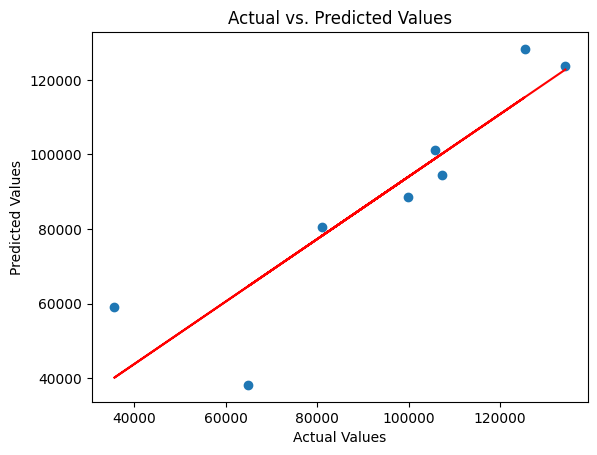

Linear Regression RMSE: 14606.339720115895
Linear Regression MAE: 11647.613108779537
Linear Regression R2 Score: 0.7686321134809013


In [30]:
# Fit the models on the training data
linear_reg = k_cross_fold(X_train, y_train, linear_reg, 10)[-1]
# Make predictions on the test set
linear_reg_preds = linear_reg.predict(X_test)
linear_reg_rmse = mean_squared_error(y_test, linear_reg_preds, squared=False)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_preds)
linear_reg_r2 = r2_score(y_test, linear_reg_preds)

plottings(y_test, linear_reg_preds)

print('Linear Regression RMSE:', linear_reg_rmse)
print('Linear Regression MAE:', linear_reg_mae)
print('Linear Regression R2 Score:', linear_reg_r2)

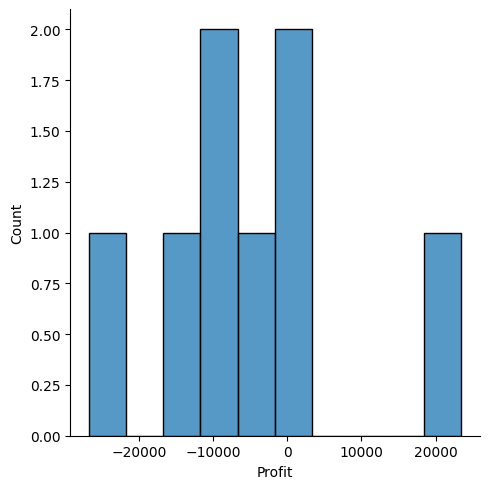

In [54]:
sns.displot(linear_reg_preds-y_test, bins=10)

In [31]:
df.loc[0] = ['Linear', linear_reg_rmse, linear_reg_mae, linear_reg_r2]

## POlynomial Regression

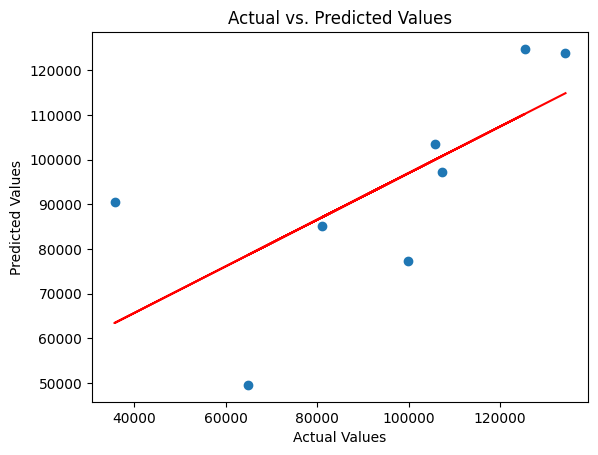

Polynomial RMSE: 22297.591309749947
Polynomial MAE: 15011.136886610147
Polynomial R2 0.46081700505593615


In [32]:
poly_reg.fit(X_train, y_train)
poly_preds = poly_reg.predict(X_test)
poly_rmse = mean_squared_error(y_test, poly_preds, squared=False)
poly_mae = mean_absolute_error(y_test, poly_preds)
poly_r2 = r2_score(y_test, poly_preds)

plottings(y_test, poly_preds)

print('Polynomial RMSE:', poly_rmse)
print('Polynomial MAE:', poly_mae)
print("Polynomial R2", poly_r2)

In [33]:
df.loc[4] = ['Polynomial', poly_rmse, poly_mae, poly_r2]

## SVR (Support Vector Regression)

For support Vector Machine we need to Standardize both the dependent and independent variable

In [34]:
Main_data.head()

,R&D Spend,Administration,Marketing Spend,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [35]:
X = Main_data[["R&D Spend", "Administration", "Marketing Spend"]]
y = Main_data["Profit"]

The y variable must be converted into suitable format

In [36]:
y = np.array(y).reshape(50,1)

In [37]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


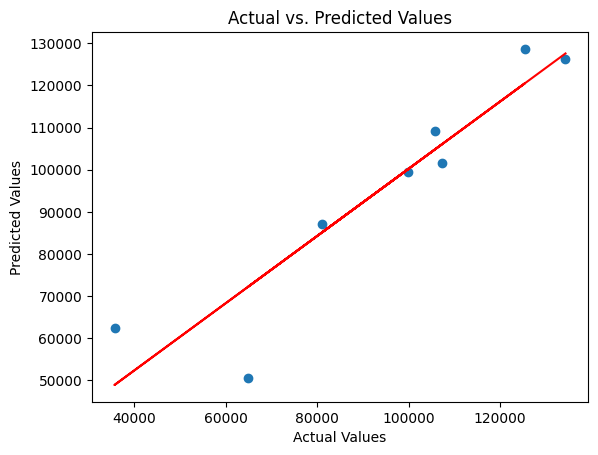

SVR RMSE: 11656.560317699003
SVR MAE: 8535.602695541413
SVR R2 Score 0.8526462762774873


In [39]:
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

actual = sc_y.inverse_transform(y_test).reshape(1,8)[0]
predicted = sc_y.inverse_transform(svr_preds.reshape(8,1)).reshape(1,8)[0]
svr_rmse = mean_squared_error(actual, predicted, squared=False)
svr_mae = mean_absolute_error(actual, predicted)
svr_r2 = r2_score(actual, predicted)

plottings(actual, predicted)

print('SVR RMSE:', svr_rmse)
print('SVR MAE:', svr_mae)
print("SVR R2 Score", svr_r2)

In [40]:
df.loc[1] = ['SVR', svr_rmse, svr_mae, svr_r2]

We have tried with different Kernel, and the best we found was linear

## Decision Tree Regressor

Data Scaling or Feature scaling is not required

In [41]:
X = Main_data[["R&D Spend", "Administration", "Marketing Spend"]]
y = Main_data["Profit"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

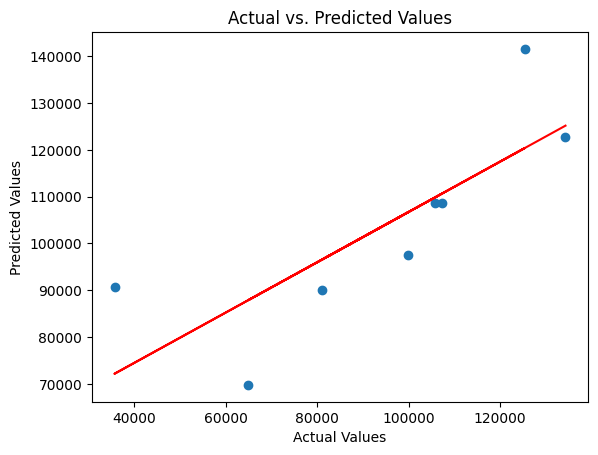

Decision Tree RMSE: 21045.58946616339
Decision Tree MAE: 12872.11625
Decision Tree R2 Score: 0.5196669461135783


In [43]:
decision_tree_reg.fit(X_train, y_train)
decision_tree_preds = decision_tree_reg.predict(X_test)
decision_tree_rmse = mean_squared_error(y_test, decision_tree_preds, squared=False)
decision_tree_mae = mean_absolute_error(y_test, decision_tree_preds)
decision_tree_r2 = r2_score(y_test, decision_tree_preds)

plottings(y_test, decision_tree_preds)

print('Decision Tree RMSE:', decision_tree_rmse)
print('Decision Tree MAE:', decision_tree_mae)
print('Decision Tree R2 Score:', decision_tree_r2)

In [44]:
df.loc[1] = ['Decision Tree', decision_tree_rmse, decision_tree_mae, decision_tree_r2]

## Random Forest Regressor

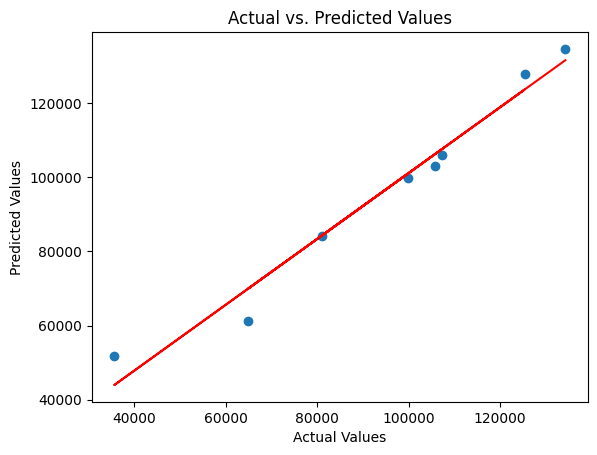

Random Forest RMSE: 6053.901378611117
Random Forest MAE: 3719.4999999999854
Random Forest R2 Score: 0.9602542251382955


In [45]:
random_forest_reg.fit(X, y)
random_forest_preds = random_forest_reg.predict(X_test)
random_forest_rmse = mean_squared_error(y_test, random_forest_preds, squared=False)
random_forest_mae = mean_absolute_error(y_test, random_forest_preds)
random_forest_r2 = r2_score(y_test, random_forest_preds)

plottings(y_test, random_forest_preds)

print('Random Forest RMSE:', random_forest_rmse)
print('Random Forest MAE:', random_forest_mae)
print('Random Forest R2 Score:', random_forest_r2)

In [46]:
df.loc[2] = ['Random Forest', random_forest_rmse, random_forest_mae, random_forest_r2]

## Graadient Boosting

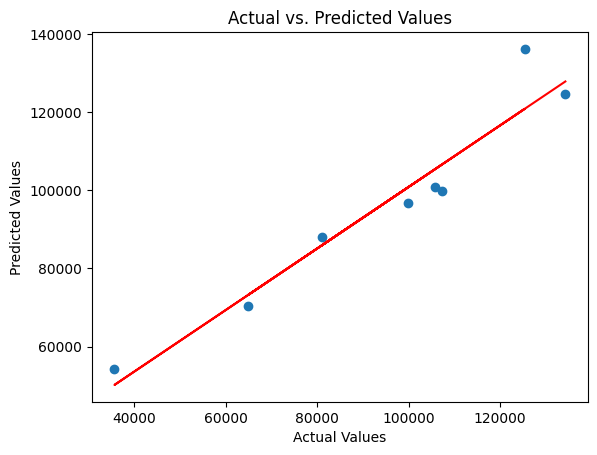

Gradient Boosting RMSE: 9527.557892724173
Gradient Boosting MAE: 8425.718999580178
Gradient Boosting R2 0.9015573089054039


In [47]:
gradient_boosting_reg.fit(X_train, y_train)
gradient_boosting_preds = gradient_boosting_reg.predict(X_test)
gradient_boosting_rmse = mean_squared_error(y_test, gradient_boosting_preds, squared=False)
gradient_boosting_mae = mean_absolute_error(y_test, gradient_boosting_preds)
gradient_boosting_r2 = r2_score(y_test, gradient_boosting_preds)

plottings(y_test, gradient_boosting_preds)

print('Gradient Boosting RMSE:', gradient_boosting_rmse)
print('Gradient Boosting MAE:', gradient_boosting_mae)
print("Gradient Boosting R2", gradient_boosting_r2)

In [48]:
df.loc[3] = ['Gradient Boosting', gradient_boosting_rmse, gradient_boosting_mae, gradient_boosting_r2]

## Choosing the best model

In [49]:
df = df.sort_values(by= ['RMSE', 'MAE', 'R2'])
df

,Regression Algorithm,RMSE,MAE,R2
2,Random Forest,6053.901379,3719.500000,0.960254
3,Gradient Boosting,9527.557893,8425.719000,0.901557
0,Linear,14606.339720,11647.613109,0.768632
1,Decision Tree,21045.589466,12872.116250,0.519667
4,Polynomial,22297.591310,15011.136887,0.460817


Saving the best model, which is Gradient Boosting

In [50]:
from joblib import Parallel, delayed
import joblib
import pickle

# Save the model as a pickle in a file
joblib.dump(random_forest_reg, 'Best_model.pkl')
# pickle.dump(scaler, open('Scaler.pkl', "wb"), protocol=0)

# Load the model from the file
Model = joblib.load('Best_model.pkl')
# Scaler = pickle.load(open('Scaler.pkl', 'rb'))
# x = Scaler.transform([data.iloc[40][:3]])
# Use the loaded model to make predictions

x = [X.iloc[40][:3]]
Model.predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([80006.6314])

In [52]:
[X.iloc[40][:3]], y[40]

([R&D Spend           28754.33
  Administration     118546.05
  Marketing Spend    172795.67
  Name: 40, dtype: float64],
 78239.91)